In [74]:
# !pip3 install tensorflow pandas numpy matplotlib yahoo_fin sklearn fredapi openpyxl

In [75]:
import sys

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random
from fredapi import Fred

import torch


In [76]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#   print('and then re-execute this cell.')
# else:
#   print(gpu_info)

In [77]:
#setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GT 730
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [78]:
# tf.test.is_built_with_cuda ()

In [79]:
# tf.test.is_gpu_available (cuda_only = False, min_cuda_compute_capability = None)

In [80]:
if tf.config.list_physical_devices('GPU'):
    print("GPU работает")
    print(tf.config.list_physical_devices('GPU'))
else:
    print("GPU не работает")
    sys.exit()

GPU работает
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [81]:
fred = Fred(api_key='39fa3bd07f8f55540a93e075a5f97cc1')

In [82]:
series_ids = [
    'CHNCPIALLMINMEI','USACPIALLMINMEI','BRACPIALLMINMEI','INDCPIALLMINMEI','BRAPROINDMISMEI'
    ,'USAPROINDMISMEI','PCUOMFGOMFG','RUSCPIALLMINMEI','PIEATI02RUM661N','RUSPROMANMISMEI'
    ,'UNRATENSA','GS10','M2NS','INTDSRUSM193N','TOTALNSA','MABMM301USM189S','ALTSALES','RSXFSN'
    ,'HTRUCKSSA','M2REAL','M1NS','BUSLOANS','MCOILWTICO','DAUPNSA','FRGSHPUSM649NCIS','PCU33443344'
    ,'AISRSA' ,'M1REAL','TRUCKD11','RAILFRTCARLOADS','MNFCTRIRNSA','DAUTOSAAR'
    ,'LTOTALNSA','MVMTD027MNFRBDAL','USEPUINDXM','CEU4348400001','CEU1021100001'
    ,'IPG3361T3S','TRESEGUSM052N','LAUTONSA','WPU114','RSGASSN','CMRMT','NATURALGAS'
    ,'EMVOVERALLEMV','PCU483111483111','WPU101706','GASREGCOVM','WPU11','PCU48214821'
    ,'WPU1413','MRTSIR441USN','U36SNO','PCU21112111','IPB53122N','IPB54100N','EXUSEU'
    ,'PCU4841214841212','GASDESM','EXCHUS','IPN213111N','PCU21212121','WPU012'
    # ,'M1109BUSM293NNBR','PCU484484','IC131','JTU2300JOL','WPU801104','WPU3011','PCU33613361'
]

In [83]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [84]:
import os
import time
from tensorflow.keras.layers import LSTM

# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 15

# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = True
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.1
# features to use
# FEATURE_COLUMNS = ["close", "volume", "open", "high", "low","ema100"]
FEATURE_COLUMNS = ["close", "volume", "open", "high", "low"
                    ,"ma7","ma21"
                      ,"ma100","ma50"
                      ,"26ema","12ema","MACD","ema","momentum"
                   ] \
                  # + series_ids

# date now
date_now = time.strftime("%Y-%m-%d")

### model parameters

N_LAYERS = 2
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False

### training parameters

# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 700

# Amazon stock market
ticker = "^GSPC"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [85]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['close'].rolling(window=21).mean()
    dataset['ma100'] = dataset['close'].rolling(window=100).mean()
    dataset['ma50'] = dataset['close'].rolling(window=50).mean()

    # Create MACD
	# candles['ema20'] = pd.Series.ewm(candles['<CLOSE>'], span=20).mean()
    dataset['26ema'] = pd.Series.ewm(dataset['close'], span=26).mean()
    dataset['12ema'] = pd.Series.ewm(dataset['close'], span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    # dataset['20sd'] = pd.stats.moments.rolling_std(dataset['GS'],20)
    # dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    # dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['close'].ewm(com=0.5).mean()

    # Create Momentum
    dataset['momentum'] = dataset['close']-1

    dataset.replace('', np.nan, inplace=True)
    dataset = dataset.dropna()

    return dataset

In [86]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)


def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['close', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_by_date (bool): whether we split the dataset into training/testing by date, setting it 
            to False will split datasets in a random way
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        # df = si.get_data(ticker)
        # df = si.get_data(ticker,start_date = '2000-01-01', end_date = None, index_as_date = True, interval= "1mo")
        df = si.get_data(ticker,start_date = '2000-01-01')
        # get_data(ticker, start_date = None, end_date = None, index_as_date = True, interval = “1d”)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")


    df = get_technical_indicators(df)
    # df_fred = get_fred()
    # df = pd.concat([df_fred , df], axis=1)

    df.replace('', np.nan, inplace=True)
    df = df.dropna()

    # print(df.tail)
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()

    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."

    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index

    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler

    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['close'].shift(-lookup_step)

    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    
    # drop NaNs
    df.dropna(inplace=True)

    sequence_data = []
    sequences = deque(maxlen=n_steps)

    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])

    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)

    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)

    return result

In [87]:
def get_fred():
    # series_ids = ['PCPI06037', 'PCPI06075', 'PCPI24510']
    # ticker_fred = 'SP500'
    # dataset_fred = fred.get_series(ticker_fred, observation_start="1/1/2000")
    # print(dataset_fred)
    # dataset_fred = pd.DataFrame({'date':dataset_fred.index.tolist(),ticker_fred:dataset_fred.tolist()})
    # dataset_fred.set_index('date', inplace=True)
    #
    # dataset = pd.concat([dataset, dataset_fred],axis=1)
    data_ = {}
    for series_id in series_ids:
        data_[series_id] = fred.get_series(series_id, observation_start='1/1/2000')
    dataset_ = pd.concat(data_, axis=1)
    dataset_.replace('', np.nan, inplace=True)
    dataset_=dataset_.fillna(dataset_[-10:].mean())
    # dataset = pd.concat([dataset , df], axis=1)
    # print(df)

    return dataset_

In [88]:
# data_s = []
# data_s = pd.DataFrame
# data_s = get_fred('SP500')
# ticker_fred = 'SP500'
# dataset_fred_ = fred.get_series(ticker_fred)
# print(dataset_fred_)
# ddf = get_fred()
# ddf

In [89]:
# ddf.to_excel("fred.xlsx")

In [90]:
# df_yaho = si.get_data(ticker,start_date = '2000-01-01', end_date = None, index_as_date = True, interval= "1mo")

In [91]:
# df_yaho

In [92]:
# df_sum = pd.concat([df_yaho,ddf],axis=1)

In [93]:
# df_sum
# df_sum.to_excel("view.xlsx")

In [94]:
# df_sum.replace('', np.nan, inplace=True)

In [95]:
# df_sum.fillna(method='ffill')
# df_sum_out=df_sum.fillna(df_sum[-10:].mean())
# df_sum = df_sum.dropna()
# data_s.to_excel("test.xlsx")
# data_s.to_excel("test.xlsx")

In [96]:
# df_sum_out

In [97]:
# df_sum_out.to_excel("view2.xlsx")

In [98]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [99]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")

if not os.path.isdir("logs"):
    os.mkdir("logs")

if not os.path.isdir("data"):
    os.mkdir("data")

# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)

# save the dataframe
# data["df"].to_csv(ticker_data_filename + ".csv")
# data["df"].to_excel("view.xlsx")
# data.to_csv(ticker_data_filename + "_2.csv")

# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

In [100]:
# data["df"]

In [101]:
data["df"].to_excel("view_start.xlsx")

In [102]:

if os.path.exists(os.path.join("results", model_name + ".h5")):
	print("Модель уже просчитана, загружаем модель")
	# model = keras.models.load_model(path_best_model)

else:
    # some tensorflow callbacks
    checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
    tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
    # train the model and save the weights whenever we see
    # a new optimal model using ModelCheckpoint
    history = model.fit(data["X_train"], data["y_train"],
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(data["X_test"], data["y_test"]),
                        callbacks=[checkpointer, tensorboard],
                        verbose=1)

Модель уже просчитана, загружаем модель


In [103]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_close_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'close_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [104]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["close"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["close"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"close_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_close_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["close"],
                                    final_df[f"close_{LOOKUP_STEP}"],
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["close"],
                                    final_df[f"close_{LOOKUP_STEP}"],
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [105]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["close"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [106]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [107]:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["close"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [108]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

In [109]:
# predict the future price
future_price = predict(model, data)

In [110]:
future_price

4667.185

In [111]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [112]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 15 days is 4667.19$
huber_loss loss: 0.0009572773124091327
Mean Absolute Error: 780.3272975621245
Accuracy score: 0.719626168224299
Total buy profit: 23661.907470703125
Total sell profit: -2362.072265625
Total profit: 21299.835205078125
Profit per trade: 39.812776084258175


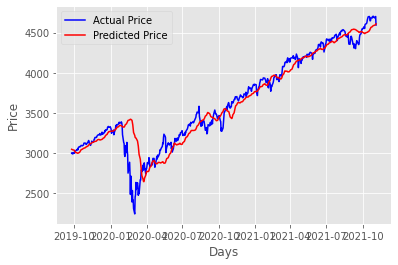

In [113]:
# plot true/pred prices graph
plot_graph(final_df)

In [114]:
final_df.head(20)

,open,high,low,close,adjclose,volume,ticker,ma7,ma21,ma100,ma50,26ema,12ema,MACD,ema,momentum,close_15,true_close_15,buy_profit,sell_profit
2019-09-24,3002.429932,3007.979980,2957.729980,2966.600098,2966.600098,3868160000,^GSPC,2995.375732,2963.267601,2921.661094,2950.006196,2966.182195,2984.227104,18.044909,2975.559045,2965.600098,3043.966309,2995.679932,29.079834,0.0
2019-09-25,2968.350098,2989.820068,2952.860107,2984.870117,2984.870117,3318870000,^GSPC,2993.505755,2968.338565,2922.053396,2949.622798,2967.566485,2984.326029,16.759543,2981.766427,2983.870117,3041.571533,2989.689941,4.819824,0.0
2019-09-26,2985.729980,2987.280029,2963.709961,2977.620117,2977.620117,3077240000,^GSPC,2989.494350,2973.503337,2922.504897,2949.486802,2968.311199,2983.294350,14.983151,2979.002220,2976.620117,3039.717285,2997.949951,20.329834,0.0
2019-09-27,2985.469971,2987.310059,2945.530029,2961.790039,2961.790039,3243650000,^GSPC,2983.074358,2977.020008,2923.282297,2948.820400,2967.828150,2979.985995,12.157845,2967.527433,2960.790039,3036.750000,2986.199951,24.409912,0.0
2019-09-30,2967.070068,2983.850098,2967.070068,2976.739990,2976.739990,3247610000,^GSPC,2978.781494,2979.503813,2924.255498,2948.822998,2968.488286,2979.486609,10.998323,2973.669138,2975.739990,3034.179688,3006.719971,29.979980,0.0
2019-10-01,2983.689941,2992.530029,2938.699951,2940.250000,2940.250000,3558040000,^GSPC,2971.378627,2980.160482,2924.950798,2947.927397,2966.396561,2973.450208,7.053646,2951.389713,2939.250000,3029.907471,2995.989990,55.739990,0.0
2019-10-02,2924.780029,2924.780029,2874.929932,2887.610107,2887.610107,3912520000,^GSPC,2956.497210,2979.271915,2925.012900,2945.570200,2960.560528,2960.244039,-0.316489,2908.869976,2886.610107,3019.895752,3004.520020,116.909912,0.0
2019-10-03,2885.379883,2911.129883,2855.939941,2910.629883,2910.629883,3503640000,^GSPC,2948.501465,2977.979050,2926.000498,2943.391597,2956.861961,2952.611092,-4.250870,2910.043247,2909.629883,3008.841797,3010.290039,99.660156,0.0
2019-10-04,2918.560059,2953.739990,2918.560059,2952.010010,2952.010010,2990830000,^GSPC,2943.807164,2976.836670,2927.176499,2942.358398,2956.502558,2952.518617,-3.983940,2938.021089,2951.010010,3003.168457,3022.550049,70.540039,0.0
2019-10-07,2944.229980,2959.750000,2935.679932,2938.790039,2938.790039,2940140000,^GSPC,2938.260010,2974.935721,2928.054800,2940.616997,2955.190519,2950.406528,-4.783991,2938.533722,2937.790039,3001.251709,3039.419922,100.629883,0.0


In [115]:
final_df.tail(20)

,open,high,low,close,adjclose,volume,ticker,ma7,ma21,ma100,ma50,26ema,12ema,MACD,ema,momentum,close_15,true_close_15,buy_profit,sell_profit
2021-10-08,4406.509766,4412.020020,4386.220215,4391.339844,4391.339844,2401890000,^GSPC,4352.201381,4399.544271,4358.030884,4437.935791,4402.339449,4378.662144,-23.677305,4389.096320,4390.339844,4495.953125,4605.379883,214.040039,0.000000
2021-10-11,4385.439941,4415.879883,4360.589844,4361.189941,4361.189941,2580000000,^GSPC,4359.865653,4394.906645,4360.485981,4437.254395,4399.291337,4375.974113,-23.317225,4370.492067,4360.189941,4500.843750,4613.669922,252.479980,0.000000
2021-10-12,4368.310059,4374.890137,4342.089844,4350.649902,4350.649902,2608150000,^GSPC,4358.952776,4389.283784,4362.401279,4436.524189,4395.688268,4372.078080,-23.610188,4357.263957,4349.649902,4503.136230,4630.649902,280.000000,0.000000
2021-10-13,4358.009766,4372.870117,4329.919922,4363.799805,4363.799805,2926460000,^GSPC,4368.001325,4385.509975,4364.480679,4435.337188,4393.326160,4370.804499,-22.521660,4361.621189,4362.799805,4503.130371,4660.569824,296.770020,0.000000
2021-10-14,4386.750000,4439.729980,4386.750000,4438.259766,4438.259766,2642920000,^GSPC,4381.221261,4383.489002,4366.892778,4436.049180,4396.654575,4381.182233,-15.472342,4412.713573,4437.259766,4506.242676,4680.060059,241.800293,0.000000
2021-10-15,4447.689941,4475.819824,4447.689941,4471.370117,4471.370117,3000560000,^GSPC,4396.624163,4383.375674,4369.725181,4436.894580,4402.189059,4395.057292,-7.131768,4451.817936,4470.370117,4512.994141,4697.529785,226.159668,0.000000
2021-10-18,4463.720215,4488.750000,4447.470215,4486.459961,4486.459961,2683540000,^GSPC,4409.009905,4385.921852,4372.629878,4437.893379,4408.431348,4409.119241,0.687892,4474.912619,4485.459961,4522.338867,4701.700195,215.240234,0.000000
2021-10-19,4497.339844,4520.399902,4496.410156,4519.629883,4519.629883,2531210000,^GSPC,4427.337054,4393.631371,4375.817378,4439.638975,4416.668277,4426.120878,9.452601,4504.724128,4518.629883,4533.880371,4685.250000,165.620117,0.000000
2021-10-20,4524.419922,4540.870117,4524.399902,4536.189941,4536.189941,2671560000,^GSPC,4452.337054,4402.298038,4379.138179,4441.627773,4425.521734,4443.054580,17.532847,4525.701337,4535.189941,4545.970215,4646.709961,110.520020,0.000000
2021-10-21,4532.240234,4551.439941,4526.890137,4549.779785,4549.779785,3016950000,^GSPC,4480.784180,4409.638021,4382.615576,4443.775166,4434.726034,4459.473843,24.747809,4541.753636,4548.779785,4556.785645,4649.270020,99.490234,0.000000


In [116]:
# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)
xlsx_filename = os.path.join(csv_results_folder, model_name + ".xlsx")
final_df.to_excel(xlsx_filename)

In [117]:
candles = final_df
import datetime
candles.rename(columns={'close_15':'predict','true_close_15':'test'}, inplace=True)

In [121]:
# Рисует основной график
def draw_candles(candles):
    # Добавим на график несколько ЕМА-средних
    # candles['ema100'] = pd.Series.ewm(candles['close'], span=100).mean()
    # candles['ema50'] = pd.Series.ewm(candles['close'], span=50).mean()
    # candles['ema20'] = pd.Series.ewm(candles['close'], span=20).mean()
    # candles['26ema'] = pd.Series.ewm(candles['close'], span=26).mean()
    # candles['12ema'] = pd.Series.ewm(candles['close'], span=12).mean()
    # candles['MACD'] = (candles['12ema']-candles['26ema'])
    plt.style.use('ggplot')  # 'seaborn-paper'
    # Отображаем график по цене закрытия свечей и ЕМА-шки
    fig = candles.plot(y=['test', 'predict','26ema','MACD','12ema'], figsize=(25, 16))
    # Добавляем заголовок
    fig.set_title('График ' + ticker)
    # Рисуем шкалу с датами
    PlotDatesX(fig, candles)

# Определяет начальную и конечную позицию Х (по индексу свечей) для заданной даты. Пригодится при отрисовке ценовых уровней
def DateX(date, candles):
    # Цикл по датам в свечах, результат - список X-координат, соответствующих заданной дате
    xpositions = [index for index, row in candles.iterrows() if row['date'].date() == date]
    # Возвращает список - пару начальная координата Х и конечная координата Х для заданной даты на графике
    if xpositions == []:
        return [len(candles) - 1, len(candles)]  # На случай если за текущую дату нет еще свечей
    return [xpositions[0], xpositions[-1]]


# Рисует метки дат на оси Х
def PlotDatesX(fig, candles):
    # Составляем список дат (только уникальные даты) из столбца DT. Они будут метками на оси Х. Сортировка по датам
    # обязательна, т.к. при создании множества(set) даже из отсортированного списка, множество может не сохранить порядок списка
    dates = sorted(set(map(lambda dt: datetime.date(dt), candles['date'])))
    # Создаем список координат Х для каждой метки (даты). Нам нужна только первая позиция - [0].
    xlabel = [DateX(d, candles)[0] for d in dates]
    # Рисуем ось Х, разделенную по датам
    fig.set_xticklabels(dates)
    fig.set_xticks(xlabel)
    return dates, xlabel

In [119]:
# candles.rename(columns={'close_15':'predict','true_close_15':'test'}, inplace=True)
# candles['Date'] = candles.index
# candles['ema100'] = pd.Series.ewm(candles['close'], span=100).mean()
# candles['ema50'] = pd.Series.ewm(candles['close'], span=50).mean()
# candles['ema20'] = pd.Series.ewm(candles['close'], span=20).mean()
# candles['26ema'] = pd.Series.ewm(candles['close'], span=26).mean()
# candles['12ema'] = pd.Series.ewm(candles['close'], span=12).mean()
# candles['MACD'] = (candles['12ema']-candles['26ema'])
# # candles['Date']= datetime.datetime.strptime(str(candles['Date']), '%Y-%m-%d').date()#pd.to_datetime(candles['Date'],format='%Y%m%d')
# candles.tail(20)

KeyError: 'date'

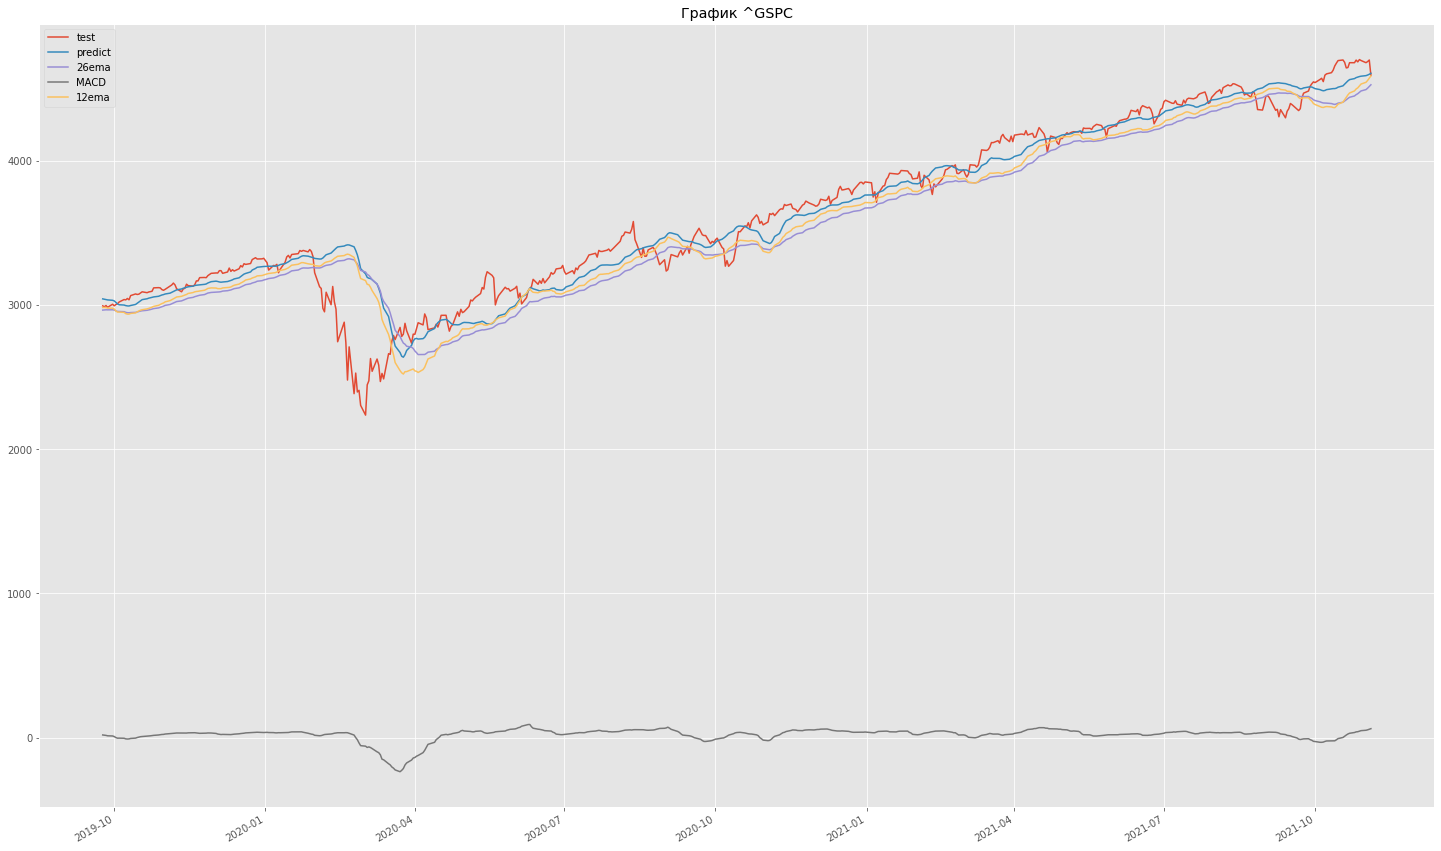

In [122]:

draw_candles(candles.tail(1000))